In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_csv("wine-reviews.csv",usecols = ['country','description','points','price','variety','winery'])

In [4]:
df = df.dropna(subset = ["description","points"])

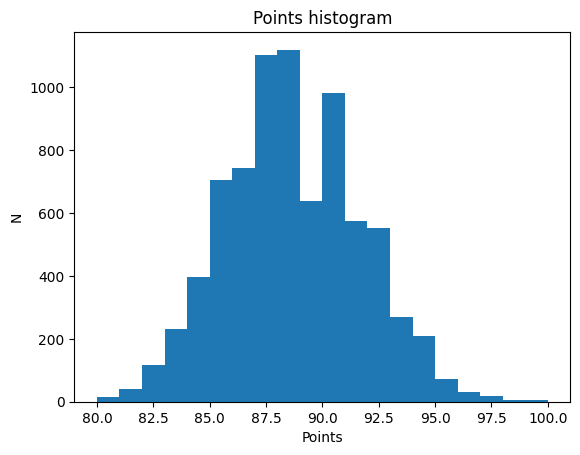

In [5]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [6]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description","points","label"]]

In [7]:
train, val , test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [8]:
len(train),len(val),len(test)

(6268, 783, 784)

In [10]:

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df =df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

### **MODEL**

In [12]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [13]:
hub_layer(list(train_ds)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.74076474, -0.06311584,  0.1445508 , ...,  0.19295345,
        -0.26412842, -0.02629015],
       [ 0.481764  , -0.29091865, -0.02205079, ..., -0.19294989,
        -0.04120614,  0.04861473],
       [ 0.54448825, -0.20580669, -0.03978067, ..., -0.11828478,
        -0.14114922, -0.10233623],
       ...,
       [ 0.5851388 , -0.00204691,  0.08901027, ...,  0.08892034,
        -0.24256447, -0.01585101],
       [ 0.61819804, -0.28913215,  0.09095501, ...,  0.06049402,
        -0.03653632, -0.08115415],
       [ 0.66201025, -0.38066202, -0.19453491, ..., -0.08092253,
         0.05130054, -0.00870172]], dtype=float32)>

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
#dropouts are added to overcome the overfitting of the data it sets the inputs to 0 randomly
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.evaluate(train_ds)

7/7 [==============================] - 1s 9ms/step - loss: 0.6846 - accuracy: 0.5946


[0.6845779418945312, 0.5946075320243835]

In [20]:
model.evaluate(val_ds)

1/1 [==============================] - 0s 28ms/step - loss: 0.6843 - accuracy: 0.5862


[0.6843154430389404, 0.5862069129943848]

In [23]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 1s 198ms/step - loss: 0.5368 - accuracy: 0.7379 - val_loss: 0.5475 - val_accuracy: 0.7369
Epoch 2/10
7/7 [==============================] - 1s 161ms/step - loss: 0.5187 - accuracy: 0.7549 - val_loss: 0.5347 - val_accuracy: 0.7382
Epoch 3/10
7/7 [==============================] - 1s 158ms/step - loss: 0.5009 - accuracy: 0.7725 - val_loss: 0.5237 - val_accuracy: 0.7420
Epoch 4/10
7/7 [==============================] - 1s 159ms/step - loss: 0.4841 - accuracy: 0.7889 - val_loss: 0.5119 - val_accuracy: 0.7561
Epoch 5/10
7/7 [==============================] - 1s 159ms/step - loss: 0.4585 - accuracy: 0.8003 - val_loss: 0.5010 - val_accuracy: 0.7522
Epoch 6/10
7/7 [==============================] - 1s 186ms/step - loss: 0.4403 - accuracy: 0.8133 - val_loss: 0.4944 - val_accuracy: 0.7548
Epoch 7/10
7/7 [==============================] - 1s 162ms/step - loss: 0.4222 - accuracy: 0.8250 - val_loss: 0.4904 - val_accuracy: 0.7561
Epoch 8/10
7/7 [====

In [24]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 25ms/step - loss: 0.4794 - accuracy: 0.7589


[0.47942227125167847, 0.7589285969734192]

### LSTM

In [27]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_ds.map(lambda text, label: text))

In [28]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.evaluate(train_ds)
model.evaluate(val_ds)

1/1 [==============================] - 0s 25ms/step - loss: 0.6920 - accuracy: 0.6398


[0.691997766494751, 0.6398467421531677]

In [37]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5
7/7 [==============================] - 1s 83ms/step - loss: 0.5847 - accuracy: 0.6677 - val_loss: 0.5858 - val_accuracy: 0.6654
Epoch 2/5
7/7 [==============================] - 1s 130ms/step - loss: 0.5451 - accuracy: 0.6980 - val_loss: 0.5432 - val_accuracy: 0.7063
Epoch 3/5
7/7 [==============================] - 1s 108ms/step - loss: 0.4907 - accuracy: 0.7593 - val_loss: 0.5206 - val_accuracy: 0.7318
Epoch 4/5
7/7 [==============================] - 1s 85ms/step - loss: 0.4748 - accuracy: 0.7936 - val_loss: 0.4860 - val_accuracy: 0.7599
Epoch 5/5
7/7 [==============================] - 1s 80ms/step - loss: 0.4406 - accuracy: 0.8151 - val_loss: 0.5162 - val_accuracy: 0.7522


In [38]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 41ms/step - loss: 0.4987 - accuracy: 0.7691


[0.4987388849258423, 0.769132673740387]